## Table of Contents

<ol>
    <li>
        <a href="#Introduction">Introduction</a>
    </li>
    <li>
        <a href="#Preparing-a-multilingual-corpus">Preparing a multilingual corpus</a>
    </li>
    <li>
        <a href="#Models-for-text-summarization">Models for text summarization</a>
    </li>
    <li>
        <a href="#Preprocessing-the-data">Preprocessing the data</a>
    </li>
    <li>
        <a href="#Metrics-for-text-summarization">Metrics for text summarization</a>
    </li>
    <li>
        <a href="#Fine-tuning-mT5-with-the-Trainer-API">Fine-tuning mT5 with the Trainer API</a>
    </li>
    <li>
        <a href="#Using-your-fine-tuned-model">Using your fine-tuned model</a>
    </li>
    <li>
        <a href="#Fine-tuning-mT5-with-🤗-Accelerate">Fine-tuning mT5 with 🤗 Accelerate</a>
    </li>
</ol>

## Introduction

In this section we’ll take a look at how Transformer models can be used to condense long documents into summaries, a task known as text summarization. This is one of the most challenging NLP tasks as it requires a range of abilities, such as understanding long passages and generating coherent text that captures the main topics in a document. However, when done well, text summarization is a powerful tool that can speed up various business processes by relieving the burden of domain experts to read long documents in detail.

Although there already exist various fine-tuned models for summarization on the [Hugging Face Hub](https://huggingface.co/models?pipeline_tag=summarization&sort=downloads), almost all of these are only suitable for English documents. So, to add a twist in this section, we’ll train a bilingual model for English and Spanish. By the end of this section, you’ll have a [model](https://huggingface.co/huggingface-course/mt5-small-finetuned-amazon-en-es) that can summarize customer reviews like the one shown here:

As we’ll see, these summaries are concise because they’re learned from the titles that customers provide in their product reviews. Let’s start by putting together a suitable bilingual corpus for this task.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

True
Tesla P40


## Preparing a multilingual corpus

We’ll use the [Multilingual Amazon Reviews Corpus](https://huggingface.co/datasets/amazon_reviews_multi) or [Amazon Reviews Multi Kaggle](https://www.kaggle.com/datasets/mexwell/amazon-reviews-multi?select=validation.csv) to create our bilingual summarizer. This corpus consists of Amazon product reviews in six languages and is typically used to benchmark multilingual classifiers. However, since each review is accompanied by a short title, we can use the titles as the target summaries for our model to learn from! To get started, let’s download the English and Spanish subsets from the Hugging Face Hub:

```python
from datasets import load_dataset

spanish_dataset = load_dataset("amazon_reviews_multi", "es")
english_dataset = load_dataset("amazon_reviews_multi", "en")
```

In [2]:
from datasets import load_dataset

# Load the CSV file
dataset = load_dataset('csv', data_files='archive/train.csv')
test_dataset = load_dataset('csv', data_files='archive/test.csv')
validation_dataset = load_dataset('csv', data_files='archive/validation.csv')
dataset["test"] = test_dataset["train"]
dataset["validation"] = test_dataset["train"] 

# Cleaning
del test_dataset
del validation_dataset

# Remove the 'Unnamed: 0' column
dataset = dataset.remove_columns(['Unnamed: 0'])

# Inspect the dataset
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 1200000
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 30000
    })
})


In [3]:
# Filter for rows where the 'language' column equals 'es'
spanish_dataset = dataset.filter(lambda example: example['language'] == 'es')
spanish_dataset

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 200000
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
})

In [4]:
# Filter for rows where the 'language' column equals 'es'
english_dataset = dataset.filter(lambda example: example['language'] == 'en')
english_dataset

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 200000
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
})

Let’s take a look at a few examples by creating a simple function that takes a random sample from the training set with the techniques we learned in [Chapter 5](https://huggingface.co/course/chapter5):

In [5]:
def show_samples(dataset, num_samples=3, seed=42):
    sample = dataset["train"].shuffle(seed=seed).select(range(num_samples))
    for example in sample:
        print(f"\n'>> Title: {example['review_title']}'")
        print(f"'>> Review: {example['review_body']}'")


show_samples(english_dataset)


'>> Title: Worked in front position, not rear'
'>> Review: 3 stars because these are not rear brakes as stated in the item description. At least the mount adapter only worked on the front fork of the bike that I got it for.'

'>> Title: meh'
'>> Review: Does it’s job and it’s gorgeous but mine is falling apart, I had to basically put it together again with hot glue'

'>> Title: Can't beat these for the money'
'>> Review: Bought this for handling miscellaneous aircraft parts and hanger "stuff" that I needed to organize; it really fit the bill. The unit arrived quickly, was well packaged and arrived intact (always a good sign). There are five wall mounts-- three on the top and two on the bottom. I wanted to mount it on the wall, so all I had to do was to remove the top two layers of plastic drawers, as well as the bottom corner drawers, place it when I wanted and mark it; I then used some of the new plastic screw in wall anchors (the 50 pound variety) and it easily mounted to the wall. 

This sample shows the diversity of reviews one typically finds online, ranging from positive to negative (and everything in between!). Although the example with the “meh” title is not very informative, the other titles look like decent summaries of the reviews themselves. Training a summarization model on all 400,000 reviews would take far too long on a single GPU, so instead we’ll focus on generating summaries for a single domain of products. To get a feel for what domains we can choose from, let’s convert `english_dataset` to a `pandas.DataFrame` and compute the number of reviews per product category:

In [6]:
english_dataset.set_format("pandas")
english_df = english_dataset["train"][:]
# Show counts for top 20 products
english_df["product_category"].value_counts()[:20]

product_category
home                      17679
apparel                   15951
wireless                  15717
other                     13418
beauty                    12091
drugstore                 11730
kitchen                   10382
toy                        8745
sports                     8277
automotive                 7506
lawn_and_garden            7327
home_improvement           7136
pet_products               7082
digital_ebook_purchase     6749
pc                         6401
electronics                6186
office_product             5521
shoes                      5197
grocery                    4730
book                       3756
Name: count, dtype: int64

The most popular products in the English dataset are about household items, clothing, and wireless electronics. To stick with the Amazon theme, though, let’s focus on summarizing book reviews — after all, this is what the company was founded on! We can see two product categories that fit the bill (`book` and `digital_ebook_purchase`), so let’s filter the datasets in both languages for just these products. As we saw in [Chapter 5](https://huggingface.co/course/chapter5), the `Dataset.filter()` function allows us to slice a dataset very efficiently, so we can define a simple function to do this:

In [7]:
def filter_books(example):
    return (
        example["product_category"] == "book"
        or example["product_category"] == "digital_ebook_purchase"
    )

Now when we apply this function to `english_dataset` and `spanish_dataset`, the result will contain just those rows involving the book categories. Before applying the filter, let’s switch the format of english_dataset from "pandas" back to "arrow":

In [8]:
english_dataset.reset_format()



We can then apply the filter function, and as a sanity check let’s inspect a sample of reviews to see if they are indeed about books:

In [9]:
spanish_books = spanish_dataset.filter(filter_books)
english_books = english_dataset.filter(filter_books)
show_samples(english_books)


'>> Title: I'm dissapointed.'
'>> Review: I guess I had higher expectations for this book from the reviews. I really thought I'd at least like it. The plot idea was great. I loved Ash but, it just didnt go anywhere. Most of the book was about their radio show and talking to callers. I wanted the author to dig deeper so we could really get to know the characters. All we know about Grace is that she is attractive looking, Latino and is kind of a brat. I'm dissapointed.'

'>> Title: Good art, good price, poor design'
'>> Review: I had gotten the DC Vintage calendar the past two years, but it was on backorder forever this year and I saw they had shrunk the dimensions for no good reason. This one has good art choices but the design has the fold going through the picture, so it's less aesthetically pleasing, especially if you want to keep a picture to hang. For the price, a good calendar'

'>> Title: Helpful'
'>> Review: Nearly all the tips useful and. I consider myself an intermediate to a

Okay, we can see that the reviews are not strictly about books and might refer to things like calendars and electronic applications such as OneNote. Nevertheless, the domain seems about right to train a summarization model on. Before we look at various models that are suitable for this task, we have one last bit of data preparation to do: combining the English and Spanish reviews as a single `DatasetDict` object. 🤗 Datasets provides a handy concatenate_datasets() function that (as the name suggests) will stack two `Dataset` objects on top of each other. So, to create our bilingual dataset, we’ll loop over each split, concatenate the datasets for that split, and shuffle the result to ensure our model doesn’t overfit to a single language:

In [10]:
from datasets import concatenate_datasets, DatasetDict

books_dataset = DatasetDict()

for split in english_books.keys():
    books_dataset[split] = concatenate_datasets(
        [english_books[split], spanish_books[split]]
    )
    books_dataset[split] = books_dataset[split].shuffle(seed=42)

# Peek at a few examples
show_samples(books_dataset)


'>> Title: Easy to follow!!!!'
'>> Review: I loved The dash diet weight loss Solution. Never hungry. I would recommend this diet. Also the menus are well rounded. Try it. Has lots of the information need thanks.'

'>> Title: PARCIALMENTE DAÑADO'
'>> Review: Me llegó el día que tocaba, junto a otros libros que pedí, pero la caja llegó en mal estado lo cual dañó las esquinas de los libros porque venían sin protección (forro).'

'>> Title: no lo he podido descargar'
'>> Review: igual que el anterior'


This certainly looks like a mix of English and Spanish reviews! Now that we have a training corpus, one final thing to check is the distribution of words in the reviews and their titles. This is especially important for summarization tasks, where short reference summaries in the data can bias the model to only output one or two words in the generated summaries. The plots below show the word distributions, and we can see that the titles are heavily skewed toward just 1-2 words:
Word count distributions for the review titles and texts.

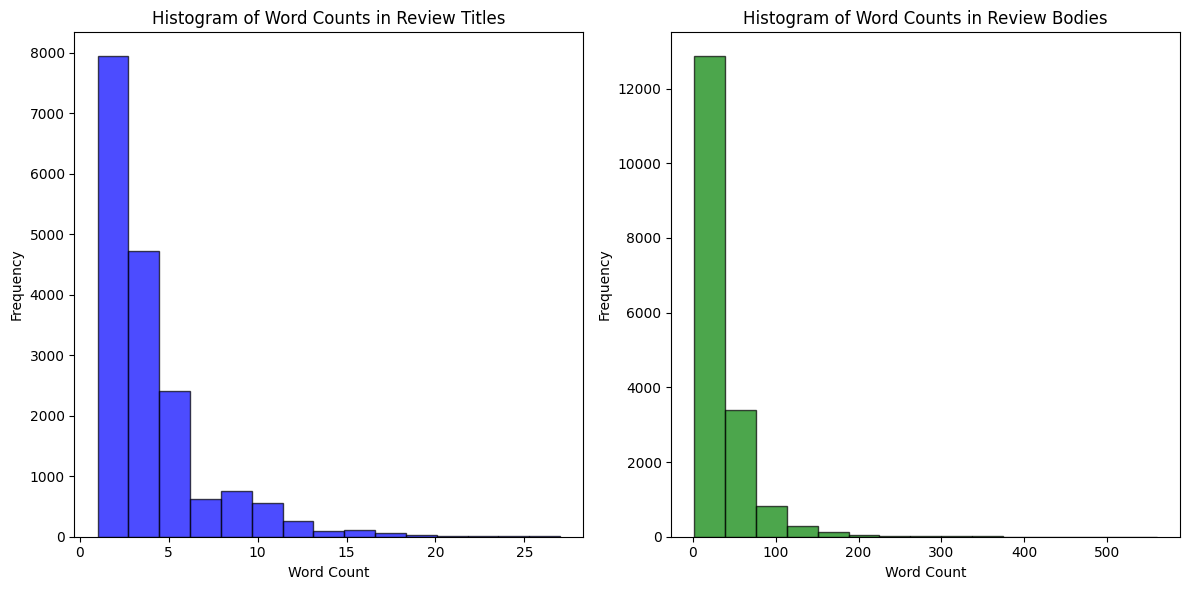

In [11]:
import matplotlib.pyplot as plt

# Function to calculate word counts
def word_count(text):
    return len(text.split())

# Prepare data for plotting
train_data = books_dataset["train"]
review_title_word_counts = [word_count(item["review_title"]) for item in train_data]
review_body_word_counts = [word_count(item["review_body"]) for item in train_data]

# Plot histograms
plt.figure(figsize=(12, 6))

# Histogram for review titles
plt.subplot(1, 2, 1)
plt.hist(review_title_word_counts, bins=15, color="blue", alpha=0.7, edgecolor="black")
plt.title("Histogram of Word Counts in Review Titles")
plt.xlabel("Word Count")
plt.ylabel("Frequency")

# Histogram for review bodies
plt.subplot(1, 2, 2)
plt.hist(review_body_word_counts, bins=15, color="green", alpha=0.7, edgecolor="black")
plt.title("Histogram of Word Counts in Review Bodies")
plt.xlabel("Word Count")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

To deal with this, we’ll filter out the examples with very short titles so that our model can produce more interesting summaries. Since we’re dealing with English and Spanish texts, we can use a rough heuristic to split the titles on whitespace and then use our trusty `Dataset.filter()` method as follows:

In [12]:
books_dataset = books_dataset.filter(lambda x: len(x["review_title"].split()) > 2)

Now that we’ve prepared our corpus, let’s take a look at a few possible Transformer models that one might fine-tune on it!

In [13]:
books_dataset

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 9672
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 245
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 245
    })
})

## Models for text summarization

If you think about it, text summarization is a similar sort of task to machine translation: we have a body of text like a review that we’d like to “translate” into a shorter version that captures the salient features of the input. Accordingly, most Transformer models for summarization adopt the encoder-decoder architecture that we first encountered in [Chapter 1](https://huggingface.co/course/chapter1), although there are some exceptions like the GPT family of models which can also be used for summarization in few-shot settings. The following table lists some popular pretrained models that can be fine-tuned for summarization.

Here is the content formatted as a table:

| Transformer Model | Description | Multilingual? |
|-------------------|-------------|---------------|
| [GPT-2](https://huggingface.co/gpt2-xl) | Although trained as an auto-regressive language model, you can make GPT-2 generate summaries by appending “TL;DR” at the end of the input text. | ❌ |
| [PEGASUS](https://huggingface.co/google/pegasus-large) | Uses a pretraining objective to predict masked sentences in multi-sentence texts. This pretraining objective is closer to summarization than vanilla language modeling and scores highly on popular benchmarks. | ❌ |
| [T5](https://huggingface.co/t5-base) | A universal Transformer architecture that formulates all tasks in a text-to-text framework; e.g., the input format for the model to summarize a document is summarize: ARTICLE. | ❌ |
| [mT5](https://huggingface.co/google/mt5-base) | A multilingual version of T5, pretrained on the multilingual Common Crawl corpus (mC4), covering 101 languages. | ✅ |
| [BART](https://huggingface.co/facebook/bart-base) | A novel Transformer architecture with both an encoder and a decoder stack trained to reconstruct corrupted input that combines the pretraining schemes of BERT and GPT-2. | ❌ |
| [mBART-50](https://huggingface.co/facebook/mbart-large-50) | A multilingual version of BART, pretrained on 50 languages. | ✅ |

As you can see from this table, the majority of Transformer models for summarization (and indeed most NLP tasks) are monolingual. This is great if your task is in a “high-resource” language like English or German, but less so for the thousands of other languages in use across the world. Fortunately, there is a class of multilingual Transformer models, like mT5 and mBART, that come to the rescue. These models are pretrained using language modeling, but with a twist: instead of training on a corpus of one language, they are trained jointly on texts in over 50 languages at once!

We’ll focus on mT5, an interesting architecture based on T5 that was pretrained in a text-to-text framework. In T5, every NLP task is formulated in terms of a prompt prefix like summarize: which conditions the model to adapt the generated text to the prompt. As shown in the figure below, this makes T5 extremely versatile, as you can solve many tasks with a single model!

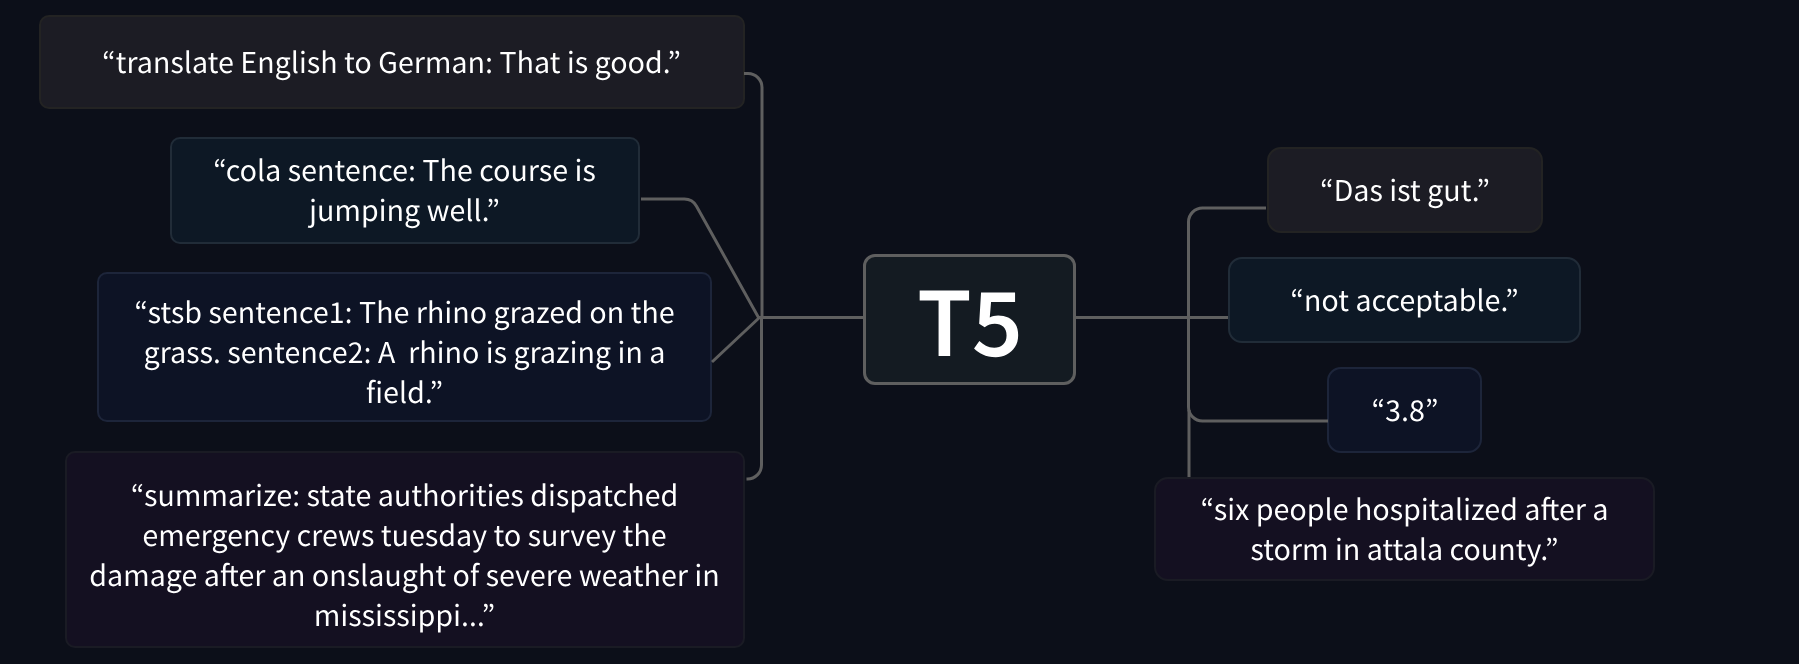

mT5 doesn’t use prefixes, but shares much of the versatility of T5 and has the advantage of being multilingual. Now that we’ve picked a model, let’s take a look at preparing our data for training.

✏️ Try it out! Once you’ve worked through this section, see how well mT5 compares to mBART by fine-tuning the latter with the same techniques. For bonus points, you can also try fine-tuning T5 on just the English reviews. Since T5 has a special prefix prompt, you’ll need to prepend summarize: to the input examples in the preprocessing steps below.

##  Preprocessing the data

Our next task is to tokenize and encode our reviews and their titles. As usual, we begin by loading the tokenizer associated with the pretrained model checkpoint. We’ll use `mt5-small` as our checkpoint so we can fine-tune the model in a reasonable amount of time:

In [14]:
from transformers import AutoTokenizer

model_checkpoint = "google/mt5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/home/loc/miniconda3/envs/py38/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/loc/miniconda3/envs/py38/lib/python3.8/site-packages/transformers/convert_slow_tokenizer.py:558: UserWarning: The sentence

💡 In the early stages of your NLP projects, a good practice is to train a class of “small” models on a small sample of data. This allows you to debug and iterate faster toward an end-to-end workflow. Once you are confident in the results, you can always scale up the model by simply changing the model checkpoint!

Let’s test out the mT5 tokenizer on a small example:

In [15]:
inputs = tokenizer("I loved reading the Hunger Games!")
inputs

{'input_ids': [336, 259, 28387, 11807, 287, 62893, 295, 12507, 309, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Here we can see the familiar `input_ids` and `attention_mask` that we encountered in our first fine-tuning experiments back in [Chapter 3](https://huggingface.co/course/chapter3). Let’s decode these input IDs with the tokenizer’s `convert_ids_to_tokens()` function to see what kind of tokenizer we’re dealing with:

In [16]:
tokenizer.convert_ids_to_tokens(inputs.input_ids)

['▁I', '▁', 'loved', '▁reading', '▁the', '▁Hung', 'er', '▁Games', '!', '</s>']

The special Unicode character `▁` and end-of-sequence token `</s>` indicate that we’re dealing with the SentencePiece tokenizer, which is based on the Unigram segmentation algorithm discussed in [Chapter 6](https://huggingface.co/course/chapter6). Unigram is especially useful for multilingual corpora since it allows SentencePiece to be agnostic about accents, punctuation, and the fact that many languages, like Japanese, do not have whitespace characters.

To tokenize our corpus, we have to deal with a subtlety associated with summarization: because our labels are also text, it is possible that they exceed the model’s maximum context size. This means we need to apply truncation to both the reviews and their titles to ensure we don’t pass excessively long inputs to our model. The tokenizers in 🤗 Transformers provide a nifty `text_target` argument that allows you to tokenize the labels in parallel to the inputs. Here is an example of how the inputs and targets are processed for mT5:

In [17]:
max_input_length = 512
max_target_length = 30


def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["review_body"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["review_title"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

Let’s walk through this code to understand what’s happening. The first thing we’ve done is define values for `max_input_length` and `max_target_length`, which set the upper limits for how long our reviews and titles can be. Since the review body is typically much larger than the title, we’ve scaled these values accordingly.

With `preprocess_function()`, it is then a simple matter to tokenize the whole corpus using the handy `Dataset.map()` function we’ve used extensively throughout this course:

In [18]:
tokenized_datasets = books_dataset.map(preprocess_function, batched=True)

Now that the corpus has been preprocessed, let’s take a look at some metrics that are commonly used for summarization. As we’ll see, there is no silver bullet when it comes to measuring the quality of machine-generated text.

💡 You may have noticed that we used `batched=True` in our `Dataset.map()` function above. This encodes the examples in batches of 1,000 (the default) and allows you to make use of the multithreading capabilities of the fast tokenizers in 🤗 Transformers. Where possible, try using `batched=True` to get the most out of your preprocessing!

## Metrics for text summarization

In comparison to most of the other tasks we’ve covered in this course, measuring the performance of text generation tasks like summarization or translation is not as straightforward. For example, given a review like “I loved reading the Hunger Games”, there are multiple valid summaries, like “I loved the Hunger Games” or “Hunger Games is a great read”. Clearly, applying some sort of exact match between the generated summary and the label is not a good solution — even humans would fare poorly under such a metric, because we all have our own writing style.

For summarization, one of the most commonly used metrics is the [ROUGE score](https://en.wikipedia.org/wiki/ROUGE_(metric)) (short for Recall-Oriented Understudy for Gisting Evaluation). The basic idea behind this metric is to compare a generated summary against a set of reference summaries that are typically created by humans. To make this more precise, suppose we want to compare the following two summaries:

In [19]:
generated_summary = "I absolutely loved reading the Hunger Games"
reference_summary = "I loved reading the Hunger Games"

🙋 Don’t worry if this is the first time you’ve heard of precision and recall — we’ll go through some explicit examples together to make it all clear. These metrics are usually encountered in classification tasks, so if you want to understand how precision and recall are defined in that context, we recommend checking out the scikit-learn guides.

**Recall**  
Recall measures how much of the reference summary is captured by the generated one. If we are just comparing words, recall can be calculated using the following formula:  

\$
\text{Recall} = \frac{\text{Number of overlapping words}}{\text{Total number of words in reference summary}}
\$  

For the simple example above, this formula gives a perfect recall of $ \frac{6}{6} = 1 $; i.e., all the words in the reference summary have been produced by the model.  

This may sound great, but imagine if the generated summary was:  
*“I really really loved reading the Hunger Games all night.”*  

This would also have a perfect recall, but it is arguably a worse summary since it is verbose.  


**Precision**  
To address verbosity, we also compute **precision**, which measures how much of the generated summary is relevant:  

\$
\text{Precision} = \frac{\text{Number of overlapping words}}{\text{Total number of words in generated summary}}
\$  

Applying this to the verbose summary gives a precision of $ \frac{6}{10} = 0.6 $, which is considerably worse than the precision of $ \frac{6}{7} \approx 0.86 $ obtained by the shorter one.  


**F1-Score**  
In practice, both precision and recall are computed, and then the **F1-score** (the harmonic mean of precision and recall) is reported.  


**Implementation with 🤗 Datasets**
You can compute ROUGE metrics easily by first installing the `rouge_score` package:  

```bash
pip install rouge_score
```

and then loading the ROUGE metric as follows:

In [20]:
import evaluate

rouge_score = evaluate.load("rouge")

Then we can use the `rouge_score.compute()` function to calculate all the metrics at once:

In [21]:
scores = rouge_score.compute(
    predictions=[generated_summary], references=[reference_summary]
)
scores

{'rouge1': 0.923076923076923,
 'rouge2': 0.7272727272727272,
 'rougeL': 0.923076923076923,
 'rougeLsum': 0.923076923076923}

Whoa, there’s a lot of information in that output — what does it all mean? First, 🤗 Datasets actually computes confidence intervals for precision, recall, and F1-score; these are the low, mid, and high attributes you can see here. Moreover, 🤗 Datasets computes a variety of ROUGE scores which are based on different types of text granularity when comparing the generated and reference summaries. The rouge1 variant is the overlap of unigrams — this is just a fancy way of saying the overlap of words and is exactly the metric we’ve discussed above. To verify this, let’s pull out the mid value of our scores:

```python

scores["rouge1"].mid
```

```
Score(precision=0.86, recall=1.0, fmeasure=0.92)
```

Great, the precision and recall numbers match up! Now what about those other ROUGE scores? rouge2 measures the overlap between bigrams (think the overlap of pairs of words), while rougeL and rougeLsum measure the longest matching sequences of words by looking for the longest common substrings in the generated and reference summaries. The “sum” in rougeLsum refers to the fact that this metric is computed over a whole summary, while rougeL is computed as the average over individual sentences.


✏️ Try it out! Create your own example of a generated and reference summary and see if the resulting ROUGE scores agree with a manual calculation based on the formulas for precision and recall. For bonus points, split the text into bigrams and compare the precision and recall for the rouge2 metric.

We’ll use these ROUGE scores to track the performance of our model, but before doing that let’s do something every good NLP practitioner should do: create a strong, yet simple baseline!

###  Creating a strong baseline

A common baseline for text summarization is to simply take the first three sentences of an article, often called the lead-3 baseline. We could use full stops to track the sentence boundaries, but this will fail on acronyms like “U.S.” or “U.N.” — so instead we’ll use the nltk library, which includes a better algorithm to handle these cases. You can install the package using pip as follows: `!pip install nltk`

and then download the punctuation rules:

In [22]:
import nltk

nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/loc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Next, we import the sentence tokenizer from `nltk` and create a simple function to extract the first three sentences in a review. The convention in text summarization is to separate each summary with a newline, so let’s also include this and test it on a training example:

In [23]:
from nltk.tokenize import sent_tokenize


def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])


print(three_sentence_summary(books_dataset["train"][1]["review_body"]))

I grew up reading Koontz, and years ago, I stopped,convinced i had "outgrown" him.
Still,when a friend was looking for something suspenseful too read, I suggested Koontz.
She found Strangers.




This seems to work, so let’s now implement a function that extracts these “summaries” from a dataset and computes the ROUGE scores for the baseline:

In [24]:
def evaluate_baseline(dataset, metric):
    summaries = [three_sentence_summary(text) for text in dataset["review_body"]]
    return metric.compute(predictions=summaries, references=dataset["review_title"])

We can then use this function to compute the ROUGE scores over the validation set and prettify them a bit using Pandas:

In [25]:
import pandas as pd

score = evaluate_baseline(books_dataset["validation"], rouge_score)
score

{'rouge1': 0.14791769321146975,
 'rouge2': 0.07072292730605598,
 'rougeL': 0.13549262793667455,
 'rougeLsum': 0.13880224614096986}

##  Fine-tuning mT5 with the Trainer API

Fine-tuning a model for summarization is very similar to the other tasks we’ve covered in this chapter. The first thing we need to do is load the pretrained model from the `mt5-small` checkpoint. Since summarization is a sequence-to-sequence task, we can load the model with the `AutoModelForSeq2SeqLM` class, which will automatically download and cache the weights:

In [26]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

💡 If you’re wondering why you don’t see any warnings about fine-tuning the model on a downstream task, that’s because for sequence-to-sequence tasks we keep all the weights of the network. Compare this to our text classification model in [Chapter 3](https://huggingface.co/course/chapter3), where the head of the pretrained model was replaced with a randomly initialized network.

The next thing we need to do is log in to the Hugging Face Hub. If you’re running this code in a notebook, you can do so with the following utility function:

```python
from huggingface_hub import notebook_login

notebook_login()
```

which will display a widget where you can enter your credentials. Alternatively, you can run this command in your terminal and log in there: `huggingface-cli login`

We’ll need to generate summaries in order to compute ROUGE scores during training. Fortunately, 🤗 Transformers provides dedicated Seq2SeqTrainingArguments and Seq2SeqTrainer classes that can do this for us automatically! To see how this works, let’s first define the hyperparameters and other arguments for our experiments:

In [27]:
from transformers import Seq2SeqTrainingArguments

batch_size = 8
num_train_epochs = 8
# Show the training loss with every epoch
logging_steps = len(tokenized_datasets["train"]) // batch_size

print("number of samples=",len(tokenized_datasets["train"]))
print("logging_steps=",logging_steps)

model_name = model_checkpoint.split("/")[-1]

args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned-amazon-en-es",
    evaluation_strategy="epoch",
    learning_rate=5.6e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True, # we should generate summaries during evaluation so that we can compute ROUGE scores for each epoch
    logging_steps=logging_steps,
    push_to_hub=True,
)

number of samples= 9672
logging_steps= 1209


/home/loc/miniconda3/envs/py38/lib/python3.8/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


The next thing we need to do is provide the trainer with a `compute_metrics()` function so that we can evaluate our model during training. For summarization this is a bit more involved than simply calling `rouge_score.compute()` on the model’s predictions, since we need to decode the outputs and labels into text before we can compute the ROUGE scores. The following function does exactly that, and also makes use of the `sent_tokenize()` function from `nltk` to separate the summary sentences with newlines:

In [28]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    # Compute ROUGE scores
    result = rouge_score.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract the median scores
    # result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    # return {k: round(v, 4) for k, v in result.items()}
    return result

Next, we need to define a data collator for our sequence-to-sequence task. Since mT5 is an encoder-decoder Transformer model, one subtlety with preparing our batches is that during decoding we need to shift the labels to the right by one. This is required to ensure that the decoder only sees the previous ground truth labels and not the current or future ones, which would be easy for the model to memorize. This is similar to how masked self-attention is applied to the inputs in a task like [causal language modeling](https://huggingface.co/course/chapter7/6).

Luckily, 🤗 Transformers provides a `DataCollatorForSeq2Seq` collator that will dynamically pad the inputs and the labels for us. To instantiate this collator, we simply need to provide the `tokenizer` and `model`:

In [29]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

Let’s see what this collator produces when fed a small batch of examples. First, we need to remove the columns with strings because the collator won’t know how to pad these elements:

In [30]:
tokenized_datasets = tokenized_datasets.remove_columns(
    books_dataset["train"].column_names
)

Since the collator expects a list of `dicts`, where each `dict` represents a single example in the dataset, we also need to wrangle the data into the expected format before passing it to the data collator:

In [31]:
features = [tokenized_datasets["train"][i] for i in range(2)]
data_collator(features)

{'input_ids': tensor([[   653,   1957,   1314,    261,   2757,   1280,    435,    259,  29166,
            263,    269,    774,   5547,      1,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              

The main thing to notice here is that the first example is longer than the second one, so the `input_ids` and `attention_mask` of the second example have been padded on the right with a `[PAD]` token (whose ID is `0`). Similarly, we can see that the `labels` have been padded with `-100`s, to make sure the padding tokens are ignored by the loss function. And finally, we can see a new `decoder_input_ids` which has shifted the labels to the right by inserting a `[PAD]` token in the first entry.

We finally have all the ingredients we need to train with! We now simply need to instantiate the trainer with the standard arguments:

In [32]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

During training, you should see the training loss decrease and the ROUGE scores increase with each epoch. Once the training is complete, you can see the final ROUGE scores by running `Trainer.evaluate()`:

In [33]:
trainer.evaluate()

/home/loc/miniconda3/envs/py38/lib/python3.8/site-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'eval_loss': 21.85244369506836,
 'eval_model_preparation_time': 0.0017,
 'eval_rouge1': 0.0009544740973312402,
 'eval_rouge2': 0.0,
 'eval_rougeL': 0.0009544740973312402,
 'eval_rougeLsum': 0.0009544740973312402,
 'eval_runtime': 2.9794,
 'eval_samples_per_second': 82.232,
 'eval_steps_per_second': 10.405}

and launch our training run:

In [34]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Rouge1,Rouge2,Rougel,Rougelsum
1,6.668700,3.326033,0.001700,0.131507,0.042952,0.125352,0.126792
2,3.894100,3.172322,0.001700,0.147006,0.055193,0.140776,0.140796
3,3.596200,3.144613,0.001700,0.159991,0.068402,0.151908,0.153612
4,3.416500,3.109553,0.001700,0.167544,0.073172,0.159122,0.160093
5,3.313100,3.087152,0.001700,0.154362,0.066831,0.148077,0.148900
6,3.255400,3.082428,0.001700,0.158913,0.066155,0.151874,0.152674
7,3.200600,3.075292,0.001700,0.160016,0.069352,0.153378,0.153668
8,3.183400,3.076189,0.001700,0.158913,0.070015,0.151508,0.152167


/home/loc/miniconda3/envs/py38/lib/python3.8/site-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/loc/miniconda3/envs/py38/lib/python3.8/site-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/loc/miniconda3/envs/py38/lib/python3.8/site-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/loc/miniconda3/envs/py38/lib/python3.8/site-packages/transformers/generation/utils.py:1220:

TrainOutput(global_step=9672, training_loss=3.816016412550403, metrics={'train_runtime': 2012.2887, 'train_samples_per_second': 38.452, 'train_steps_per_second': 4.806, 'total_flos': 1.187112454422528e+16, 'train_loss': 3.816016412550403, 'epoch': 8.0})

Evaluate after training

In [35]:
trainer.evaluate()

{'eval_loss': 3.0761890411376953,
 'eval_model_preparation_time': 0.0017,
 'eval_rouge1': 0.15891257628475844,
 'eval_rouge2': 0.07001497633735057,
 'eval_rougeL': 0.15150777019556166,
 'eval_rougeLsum': 0.15216748186300075,
 'eval_runtime': 5.1171,
 'eval_samples_per_second': 47.879,
 'eval_steps_per_second': 6.058,
 'epoch': 8.0}

From the scores we can see that our model has handily outperformed our lead-3 baseline — nice! The final thing to do is push the model weights to the Hub, as follow
```
trainer.push_to_hub(commit_message="Training complete", tags="summarization")
```

This will save the checkpoint and configuration files to output_dir, before uploading all the files to the Hub. By specifying the tags argument, we also ensure that the widget on the Hub will be one for a summarization pipeline instead of the default text generation one associated with the mT5 architecture (for more information about model tags, see the 🤗 Hub documentation). The output from trainer.push_to_hub() is a URL to the Git commit hash, so you can easily see the changes that were made to the model repository!

To wrap up this section, let’s take a look at how we can also fine-tune mT5 using the low-level features provided by 🤗 Accelerate.

##  Using your fine-tuned model

Once you’ve pushed the model to the Hub, you can play with it either via the inference widget or with a pipeline object, as follows:

In [36]:
from transformers import pipeline

hub_model_id = "mt5-small-finetuned-amazon-en-es"
summarizer = pipeline("summarization", model=hub_model_id)

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
/home/loc/miniconda3/envs/py38/lib/python3.8/site-packages/transformers/convert_slow_tokenizer.py:558: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


We can feed some examples from the test set (which the model has not seen) to our pipeline to get a feel for the quality of the summaries. First let’s implement a simple function to show the review, title, and generated summary together:

In [37]:
def print_summary(idx):
    review = books_dataset["test"][idx]["review_body"]
    title = books_dataset["test"][idx]["review_title"]
    summary = summarizer(books_dataset["test"][idx]["review_body"])[0]["summary_text"]
    print(f"'>>> Review: {review}'")
    print(f"\n'>>> Title: {title}'")
    print(f"\n'>>> Summary: {summary}'")

Let’s take a look at one of the English examples we get:

In [38]:
print_summary(100)

Your max_length is set to 20, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


'>>> Review: Muy apropiado para mis hijas'

'>>> Title: Libros para el verano'

'>>> Summary: Muy buen libro'


In [39]:
print_summary(19)

'>>> Review: El envío muy rápido, el mismo día del lanzamiento del libro. La lástima es que me lo han mandado algo deteriorado, en la parte superior hay una zona que está como rasgada. Era para un regalo.'

'>>> Title: La rápida entrega'

'>>> Summary: El envío muy rápido'


This is not too bad! We can see that our model has actually been able to perform abstractive summarization by augmenting parts of the review with new words. And perhaps the coolest aspect of our model is that it is bilingual, so we can also generate summaries of Spanish reviews:

In [40]:
print_summary(0)

'>>> Review: Es una trilogia que se hace muy facil de leer. Me ha gustado, no me esperaba el final para nada'

'>>> Title: Buena literatura para adolescentes'

'>>> Summary: No me esperaba el final'


In [41]:
print_summary(1)

'>>> Review: product arrived bent on all corners. the bubble mailer alone will not ship it in perfect condition. :('

'>>> Title: the bubble mailer alone will not ship it in perfect condition.'

'>>> Summary: Packaging arrived bent on all corners'


In [42]:
print_summary(2)

'>>> Review: Cook delicious, healthy and easy to prepare straight from my kitchen. This book all foods very good take this book you can weight loss easily.You can improve self-confidence day by day.'

'>>> Title: I recommend this book.'

'>>> Summary: Delicious, healthy and easy to prepare straight from my kitchen'


The summary translates into “Very easy to read” in English, which we can see in this case was extracted directly from the review. Nevertheless, this shows the versatility of the mT5 model and has given you a taste of what it’s like to deal with a multilingual corpus!

Next, we’ll turn our attention to a slightly more complex task: training a language model from scratch.

##  Fine-tuning mT5 with 🤗 Accelerate

Fine-tuning our model with 🤗 Accelerate is very similar to the text classification example we encountered in Chapter 3. The main differences will be the need to explicitly generate our summaries during training and define how we compute the ROUGE scores (recall that the Seq2SeqTrainer took care of the generation for us). Let’s take a look how we can implement these two requirements within 🤗 Accelerate!

###  Preparing everything for training

The first thing we need to do is create a `DataLoader` for each of our splits. Since the PyTorch dataloaders expect batches of tensors, we need to set the format to `"torch"` in our datasets:

In [43]:
tokenized_datasets.set_format("torch")

Now that we’ve got datasets consisting of just tensors, the next thing to do is instantiate the `DataCollatorForSeq2Seq` again. For this we need to provide a fresh version of the model, so let’s load it again from our cache:

In [44]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

We can then instantiate the data collator and use this to define our dataloaders:

In [45]:
from torch.utils.data import DataLoader

batch_size = 8
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size,
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], collate_fn=data_collator, batch_size=batch_size
)

The next thing to do is define the optimizer we want to use. As in our other examples, we’ll use `AdamW`, which works well for most problems:

In [46]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

Finally, we feed our model, optimizer, and dataloaders to the `accelerator.prepare()` method:

In [47]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

🚨 If you’re training on a TPU, you’ll need to move all the code above into a dedicated training function. See Chapter 3 for more details.

Now that we’ve prepared our objects, there are three remaining things to do:

- Define the learning rate schedule.

- Implement a function to post-process the summaries for evaluation.

- Create a repository on the Hub that we can push our model to.

For the learning rate schedule, we’ll use the standard linear one from previous sections:

In [48]:
from transformers import get_scheduler

num_train_epochs = 10
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

For post-processing, we need a function that splits the generated summaries into sentences that are separated by newlines. This is the format the ROUGE metric expects, and we can achieve this with the following snippet of code:

In [49]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # ROUGE expects a newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

This should look familiar to you if you recall how we defined the compute_metrics() function of the `Seq2SeqTrainer`.

Finally, we need to create a model repository on the Hugging Face Hub. For this, we can use the appropriately titled 🤗 Hub library. We just need to define a name for our repository, and the library has a utility function to combine the repository ID with the user profile:

```python
from huggingface_hub import get_full_repo_name

model_name = "test-bert-finetuned-squad-accelerate"
repo_name = get_full_repo_name(model_name)
repo_name
```

Now we can use this repository name to clone a local version to our results directory that will store the training artifacts:

```python
from huggingface_hub import Repository

output_dir = "results-mt5-finetuned-squad-accelerate"
repo = Repository(output_dir, clone_from=repo_name)
```
This will allow us to push the artifacts back to the Hub by calling the repo.push_to_hub() method during training! Let’s now wrap up our analysis by writing out the training loop.

###  Training loop

The training loop for summarization is quite similar to the other 🤗 Accelerate examples that we’ve encountered and is roughly split into four main steps:

- Train the model by iterating over all the examples in `train_dataloader` for each epoch.
    
- Generate model summaries at the end of each epoch, by first generating the tokens and then decoding them (and the reference summaries) into text.
    
- Compute the ROUGE scores using the same techniques we saw earlier.
    
- Save the checkpoints and push everything to the Hub. Here we rely on the nifty `blocking=False` argument of the `Repository` object so that we can push the checkpoints per epoch asynchronously. This allows us to continue training without having to wait for the somewhat slow upload associated with a GB-sized model!

These steps can be seen in the following block of code:

In [51]:
from tqdm.auto import tqdm  # Progress bar library for better visualization
import torch  # PyTorch library for deep learning
import numpy as np  # Library for numerical operations

# Initialize the progress bar to track the total number of training steps
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):  # Loop through each training epoch
    # Training phase
    model.train()  # Set the model to training mode
    for step, batch in enumerate(train_dataloader):  # Iterate over the training data
        outputs = model(**batch)  # Forward pass through the model with the batch data
        loss = outputs.loss  # Retrieve the loss value
        accelerator.backward(loss)  # Compute gradients for backpropagation

        optimizer.step()  # Update model parameters using the optimizer
        lr_scheduler.step()  # Update the learning rate based on the scheduler
        optimizer.zero_grad()  # Reset gradients for the next iteration
        progress_bar.update(1)  # Update the progress bar

    # Evaluation phase
    model.eval()  # Set the model to evaluation mode
    for step, batch in enumerate(eval_dataloader):  # Iterate over the evaluation data
        with torch.no_grad():  # Disable gradient calculation for evaluation
            # Generate tokens using the model
            generated_tokens = accelerator.unwrap_model(model).generate(
                batch["input_ids"],
                attention_mask=batch["attention_mask"],
            )

            # Pad the generated tokens across processes to ensure consistency
            generated_tokens = accelerator.pad_across_processes(
                generated_tokens, dim=1, pad_index=tokenizer.pad_token_id
            )
            labels = batch["labels"]

            # Pad labels to ensure they match the same dimensions as generated tokens
            labels = accelerator.pad_across_processes(
                batch["labels"], dim=1, pad_index=tokenizer.pad_token_id
            )

            # Gather tokens and labels across all processes and convert to NumPy arrays
            generated_tokens = accelerator.gather(generated_tokens).cpu().numpy()
            labels = accelerator.gather(labels).cpu().numpy()

            # Replace label values of -100 (used for ignored tokens) with the pad token ID
            labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
            if isinstance(generated_tokens, tuple):  # Handle tuple format if necessary
                generated_tokens = generated_tokens[0]

            # Decode predictions and labels into text for evaluation
            decoded_preds = tokenizer.batch_decode(
                generated_tokens, skip_special_tokens=True
            )
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

            # Post-process predictions and labels to prepare for metric computation
            decoded_preds, decoded_labels = postprocess_text(
                decoded_preds, decoded_labels
            )

            # Add predictions and references to compute ROUGE scores later
            rouge_score.add_batch(predictions=decoded_preds, references=decoded_labels)

    # Compute ROUGE metrics for the current epoch
    # result = rouge_score.compute()
    # Extract the median ROUGE scores and scale them by 100 for readability
    #result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    # Round the scores to 4 decimal places for presentation
    #result = {k: round(v, 4) for k, v in result.items()}
    print(f"Epoch {epoch}:", result)  # Print the evaluation results for the epoch

    # Save the model and tokenizer at the end of the epoch
    # accelerator.wait_for_everyone()  # Ensure all processes are synchronized
    # unwrapped_model = accelerator.unwrap_model(model)  # Get the base model
    # unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)  # Save the model
    # if accelerator.is_main_process:  # Ensure only the main process handles saving tokenizer and repo updates
    #     tokenizer.save_pretrained(output_dir)  # Save the tokenizer
    #     repo.push_to_hub(
    #         commit_message=f"Training in progress epoch {epoch}", blocking=False
    #     )  # Push the checkpoint to the hub


  0%|          | 0/12090 [00:00<?, ?it/s]

Epoch 0: {'rouge1': 0.016886733381331225, 'rouge2': 0.00326530612244898, 'rougeL': 0.01591944436782372, 'rougeLsum': 0.01654541936654782}
Epoch 1: {'rouge1': 0.016886733381331225, 'rouge2': 0.00326530612244898, 'rougeL': 0.01591944436782372, 'rougeLsum': 0.01654541936654782}
Epoch 2: {'rouge1': 0.016886733381331225, 'rouge2': 0.00326530612244898, 'rougeL': 0.01591944436782372, 'rougeLsum': 0.01654541936654782}
Epoch 3: {'rouge1': 0.016886733381331225, 'rouge2': 0.00326530612244898, 'rougeL': 0.01591944436782372, 'rougeLsum': 0.01654541936654782}
Epoch 4: {'rouge1': 0.016886733381331225, 'rouge2': 0.00326530612244898, 'rougeL': 0.01591944436782372, 'rougeLsum': 0.01654541936654782}
Epoch 5: {'rouge1': 0.016886733381331225, 'rouge2': 0.00326530612244898, 'rougeL': 0.01591944436782372, 'rougeLsum': 0.01654541936654782}
Epoch 6: {'rouge1': 0.016886733381331225, 'rouge2': 0.00326530612244898, 'rougeL': 0.01591944436782372, 'rougeLsum': 0.01654541936654782}
Epoch 7: {'rouge1': 0.016886733381

And that’s it! Once you run this, you’ll have a model and results that are pretty similar to the ones we obtained with the Trainer.